# Tarea 2: Regresión Logística con Softmax
- Martínez Ostoa Néstor Iván
- Aprendizaje de Máquina
- IIMAS, UNAM

---


**Descripción:** 

En este notebook trabajaremos con el conjunto de datos de créditos bancarios de un banco alemán (disponible [aquí](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)) para implementar regresión logística con softmax (*softmax regression*) para clasificar a las personas del dataset como candidatas o no para un crédito bancario. 

**Actividades:**

1. Carga de datos
2. Selección de los conjuntos de datos: entrenamiento, prueba y validación
3. Implementación del modelo de *softmax regression* (tanto de forma analítica como con gradiente descendente)
4. *5-fold crossvalidation* sobre el conjunto de entrenamiento y prueba para determinar el valor de la taza de aprendizaje $\alpha$ 
5. Prueba sobre el conjunto de validación con la mejor $\alpha$ encontrada en el paso 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## 1. Data Loading

**Descripción del dataset:**

- ```A1```: status del valor existente en la cuenta de cheques
- ```A2```: duración en meses
- ```A3```: historial crediticio 
- ```A4```: objetivo del crédito
- ```A5```: monto del crédito
- ```A6```: cuenta de ahorro
- ```A7```: empleado desde (rango de años)
- ```A8```: porcentaje de instalación
- ```A9```: status personal y sexo
- ```A10```: otros deudores
- ```A11```: residencia permanente desde
- ```A12```: propiedad
- ```A13```: edad en años
- ```A14```: otros planes de instalación
- ```A15```: status de la casa
- ```A16```: número de créditos existentes en este banco
- ```A17```: status del trabajo
- ```A18```: número de personas dependientes económicamente
- ```A19```: status del teléfono registrado
- ```A20```: status de extranjero
- ```A21```: indica si una personoa es apta o no para el crédito <- **variable a predecir**

In [2]:
df = pd.read_csv('german.data', sep='\s+')
print(f'Num rows: {df.shape[0]}\nNum cols: {df.shape[1]}')
df.head()

Num rows: 1000
Num cols: 21


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


El dataset actual cuenta con **13** variables categóricas y **7** numéricas por lo que tenemos que aplicar una codificación a las variables categóricas para poder utilizarlas en nuestro modelo. Antes de realizar la codificación, tenemos que identificar la distribución de variables categóricas en ordinales y no ordinales:

**Variables categóricas ordinales:**: ```A1```, ```A6```, ```A7```

**Variables categóricas no ordinales:** ```A3```, ```A4```, ```A9```, ```A10```, ```A12```, ```A14```, ```A15```, ```A17```, ```A19```, ```A20```

Para las variables categóricas ordinales realizaremos una codificación por etiqueta (*Label Encoding*) y para las variables categóricas no ordinales realizaremos una codificación *one-hot*. A continuación se muestra el código para esto: 

In [3]:
df = pd.read_csv('german.data', sep='\s+')


# Label Encoding
df['A1'] = LabelEncoder().fit_transform(df['A1'])
df['A6'] = LabelEncoder().fit_transform(df['A6'])
df['A7'] = LabelEncoder().fit_transform(df['A7'])

# One Hot Encoding
df = pd.get_dummies(df)


# Actualización de valores para 'A21'. Intercambio de '2' por '1'y '1' por '0'
a21_normalized = []
for val in df['A21'].values:
    val_to_append = 0 if val == 1 else 1
    a21_normalized.append(val_to_append)
df['A21'] = a21_normalized


# New Dataframe dimensions
print(f'Num rows: {df.shape[0]}\nNum cols: {df.shape[1]}')
df.head()

Num rows: 1000
Num cols: 51


,A1,A2,A5,A6,A7,A8,A11,A13,A16,A18,...,A15_A152,A15_A153,A17_A171,A17_A172,A17_A173,A17_A174,A19_A191,A19_A192,A20_A201,A20_A202
0,0,6,1169,4,4,4,4,67,2,1,...,1,0,0,0,1,0,0,1,1,0
1,1,48,5951,0,2,2,2,22,1,1,...,1,0,0,0,1,0,1,0,1,0
2,3,12,2096,0,3,2,3,49,1,2,...,1,0,0,1,0,0,1,0,1,0
3,0,42,7882,0,3,2,4,45,1,2,...,0,1,0,0,1,0,1,0,1,0
4,0,24,4870,0,2,3,4,53,2,2,...,0,1,0,0,1,0,1,0,1,0


In [4]:
# Escritura en disco del dataset principal
df.to_csv('data.csv', index=False)

## 2. Segmentación de conjuntos

En esta sección dividiremos el conjunto principal de **1000** renglones en dos conjuntos: 1) Entrenamiento y 2) Validación. Donde el conjunto de entrenamiento tendrá el **80%** de los datos mientras que el de validación tendrá el **20%** restante. Posteriormente, en la sección donde aplicaremos *5-fold cross validation* para encontrar el valor de $\delta$, subdividiremos el conjunto de entrenamiento en: 1) entrenamiento y 2) prueba

In [5]:
# Lectura del dataset
df = pd.read_csv('data.csv')

# Train validation dataset splitting
train_dataset, validation_dataset = train_test_split(df, train_size=0.8, random_state=1)
print(f'Train dataset dimensions: {train_dataset.shape}')
print(f'Validation dataset dimensions: {validation_dataset.shape}')

# Escritura de archivos
train_dataset.to_csv('train.csv', index=False)
validation_dataset.to_csv('validation.csv', index=False)

Train dataset dimensions: (800, 51)
Validation dataset dimensions: (200, 51)


## 3. Implementación del modelo

Para esta tarea implementaremos la regresión logística con *softmax*, la cual es una generalización de la regresión logística para $K$ clases distintas. En la regresión *softmax* la variable a predecir $Y$ pertenece a una de las $K$ clases: $$y_i \in \{1,2,\ldots,K\}$$

La hipótesis está dada por la función *softmax*: $$h_{\theta}(x) = \frac{e^{\theta_j^Tx}}{\sum_{j=1}^{K}\exp(\theta_j^Tx)}$$ y es una matriz de $N\times K$ dimensiones donde $N$ es la cantidad de renglones de entrada y $K$ la cantidad de clases a clasificar. 

De igual forma, la función costo está definida de la siguiente forma: $$J(\theta)=\sum_{i=1}^m\sum_{k=1}^K\mathbf{1}\{y_i=k\}\log \frac{\exp{\theta_k^Tx_i}}{\sum_{j=i}^k\exp{\theta_j^Tx_i}}$$ donde $\mathbf{1}$ es la función indicadora cuyo valor será $1$ si la expresión a evaluar es verdadera, y $0$ de lo contrario.

### 3.1 PyTorch

Para realizar la regresión logística con softmax en PyTorch necesitaremos definir los siguientes elementos: 
1. ```Data```: clase que hereda de ```Dataset``` en la cual leeremos los datos; principalmente la matriz $X$ de dimensiones $N\times 50$ y el vector $y$ de dimensiones $N\times 1$
2. ```Softmax```: modelo softmax el cual definirá el tipo de red neuronal (arquitectura) y la definición de la función ```forward```
3. Función de costo: ésta función puede ser tanto ```nn.CrossEntropy``` como ```nn.NLL```
4. Optimizador: define el algoritmo a emplear para optimizar los parámetros del modelo

--- 
Empezaremos definiendo la clase ```Data```

In [6]:
class Data(Dataset):
    def __init__(self, csv_file, y_name, X=None, y=None):
        """
            csv_file: string con la ruta al archivo csv
            y_name: string con el nombre de la columna a predecir
        """
        
        # Lectura del dataframe
        if csv_file is not None:
            df = pd.read_csv(csv_file)

        # Construcción de 'X' e 'y'
        _X = df.loc[:, df.columns != y_name].values if X is None else X
        _y = df.loc[:, y_name].values if y is None else y
        
        self.X = torch.tensor(_X, dtype=torch.float32)
        self.y = torch.tensor(_y, dtype=torch.float32)
        self.y = self.y.type(torch.LongTensor)
        
        self.len = self.X.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        

Ahora, definimos el modelo ```Softmax``` 

In [7]:
class Softmax(nn.Module):
    def __init__(self, in_size, out_size):
        """
            in_size: número de variables de entrada
            out_size: número de clases K
        """
        super(Softmax, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
        
    def forward(self, X):
        out = self.linear(X)
        return out

Finalmente, dos funciones, una para entrenar y otra para validación

In [8]:
def train(dataloader, model, loss_function, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (x, y) in enumerate(dataloader):
        # Cálculo del error de predicción
        yhat = model(x)
        loss = loss_function(yhat, y)
        
        # Backpropagation: reajustando parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0 and verbose:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        
    return loss.data
        
        
def test(dataloader, model, loss_function, optimizer, verbose=False):
    test_loss, correct = 0, 0
    num_batches = len(dataloader)
    size = len(dataloader)
    model.eval()
    
    for x, y in dataloader:
        yhat = model(x)
        test_loss += loss_function(yhat, y).item()
        correct += (yhat.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    accuracy = np.round(100*correct,2)
    
    if verbose:
        print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return accuracy

def kfold_train_and_test(epochs, learning_rate, batch_size, X_train, y_train, X_test, y_test):
    # Datasets
    training_loader = DataLoader(Data(None, None, X_train, y_train), batch_size=batch_size)
    testing_loader = DataLoader(Data(None, None, X_test, y_test), batch_size=batch_size)
    
    # Modelo
    model = Softmax(50, 2)

    # Función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Optimizador
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    
    # Entrenamiento y prueba
    accuracy_list = []

    for t in range(epochs):
        # Entrenamiento
        train(training_loader, model, criterion, optimizer)

        # Prueba
        accuracy = test(testing_loader, model, criterion, optimizer)
        accuracy_list.append(accuracy)
    
    return accuracy_list


Veamos un ejemplo de la implementación del modelo:

In [9]:
torch.manual_seed(1)

# Datos de entrenamiento
training_data = Data('train.csv', 'A21')
training_loader = DataLoader(training_data, batch_size=2)

# Datos de validación
validation_data = Data('validation.csv', 'A21')
validation_loader = DataLoader(validation_data, batch_size=3)

# Modelo
num_input = 50
num_output = 2
model = Softmax(num_input, num_output)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Entrenamiento y validación
epochs = 100
verbose = False
loss_list = []
accuracy_list = []

for t in range(epochs):
    if t % 10 == 0:
        verbose = True
        print(f"Epoch {t+1}\n-------------------------------")
    else: verbose = False
    
    # Entrenamiento
    loss_data = train(training_loader, model, criterion, optimizer, verbose)
    loss_list.append(loss_data)
    
    # Prueba
    accuracy = test(validation_loader, model, criterion, optimizer, verbose)
    accuracy_list.append(accuracy)
    
print("Done !")

Epoch 1
-------------------------------
loss: 185.161163  [    0/  800]
loss: 0.000000  [  200/  800]
loss: 3793.014404  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 88.1%, Avg loss: 1575.528315 

Epoch 11
-------------------------------
loss: 2257.712891  [    0/  800]
loss: 2400.769531  [  200/  800]
loss: 4291.176270  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 92.5%, Avg loss: 1695.273053 

Epoch 21
-------------------------------
loss: 0.000000  [    0/  800]
loss: 2139.246338  [  200/  800]
loss: 6091.318848  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 91.0%, Avg loss: 2949.974492 

Epoch 31
-------------------------------
loss: 1845.785400  [    0/  800]
loss: 1378.979492  [  200/  800]
loss: 5556.007812  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 107.5%, Avg loss: 1848.316622 

Epoch 41
-------------------------------
loss: 3205.750244  [    0/  800]
loss: 0.000000  [  200/  800]
los

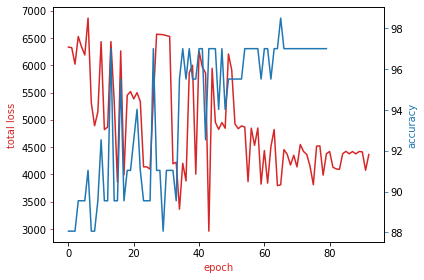

In [10]:
# Gráfica del costo vs la exactitud

fig, ax1 = plt.subplots()
color = 'tab:red'
loss_list = [loss for loss in loss_list if loss <= 1e4]
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
accuracy_list = [accuracy for accuracy in accuracy_list if accuracy <= 100]
ax2.plot( accuracy_list, color=color) 
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## 4. $k$-fold cross validation

Ya que tenemos una implementación funcional de nuestro modelo de regresión logística con softmax, veamos la forma de optimizar el parámetro $\alpha$ (taza de aprendizaje). Para esto, utilizaremos $k$*-fold cross validation* con $k=5$. 

**Primero:**
Obtendremos los datasets de entrenamiento y prueba sobre los que correremos los $5$ pliegues. El código para esto se muestra a continuación: 

In [11]:
# train.csv ya es el dataset con la codificación de variables categóricas y estandarización
df = pd.read_csv('train.csv')
X = df.loc[:, df.columns != 'A21']
y = df['A21']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Obtención de conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
print(f"------------------\nShape of X train: {X_train.shape}")
print(f"Shape of y train: {y_train.shape}")
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of uy test: {y_test.shape}")

Shape of X: (800, 50)
Shape of y: (800,)
------------------
Shape of X train: (640, 50)
Shape of y train: (640,)
Shape of X test: (160, 50)
Shape of uy test: (160,)


**Segundo:** Realizaremos pruebas para encontrar el mejor valor de $\alpha$ sobre cada uno de los $5$ pliegues. En la siguiente tabla se muestran los valores de $\alpha$ que evaluaremos.

| $\alpha$ |
|----------|
| $0.1$    |
| $0.01$   |
| $0.05$   |
| $0.001$  |
| $0.005$  |

A continuación se muestra el código

In [12]:
def custom_min(errors, alphas):
    min_error = 0
    min_delta = None
    for delta, error in zip(alphas, errors):
        if error > min_error:
            min_error = error
            min_delta = delta
    return min_error, min_delta

In [13]:
torch.manual_seed(1)

kf = KFold(n_splits=5)
alphas = [0.1, 0.01, 0.001, 0.005, 0.0001]
alphas_accuracies = []
epochs = 100
batch_size = 1
max_errors = []

# Entrenamiento con 5 pliegues
for idx, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {idx+1}\n-------------------------------")

    # Separación K-fold
    X_train_k, X_test_k = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
    y_train_k, y_test_k = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
        
    # Entrenamiento y prueba con PyTorch
    lr = alphas[idx]
    accuracy_list = kfold_train_and_test(
        epochs, lr, batch_size, X_train_k.values, y_train_k.values,
        X_test_k.values, y_test_k.values
    )
    
    # Minmax
    accuracy = accuracy_list[-1]
    max_errors.append(accuracy)
    
    # Impresión de valores
    print(f"Learning rate (alpha): {lr}")
    print(f"Accuracy: {accuracy}\n")

Fold 1
-------------------------------
Learning rate (alpha): 0.1
Accuracy: 70.31

Fold 2
-------------------------------
Learning rate (alpha): 0.01
Accuracy: 67.19

Fold 3
-------------------------------
Learning rate (alpha): 0.001
Accuracy: 76.56

Fold 4
-------------------------------
Learning rate (alpha): 0.005
Accuracy: 64.06

Fold 5
-------------------------------
Learning rate (alpha): 0.0001
Accuracy: 36.72



In [14]:
# Mejor valor de exactitud
best_accuracy, best_alpha = custom_min(max_errors, alphas)
print(f'Best accuracy: {best_accuracy}\nBest alpha: {best_alpha}')

Best accuracy: 76.56
Best alpha: 0.001


## 5. Prueba con el mejor valor de $\alpha$ encontrado en el cross validation

Para esta última sección utilizaremos el $\alpha$ encontrado en el **punto 4** para evaluar los resultados finales sobre el conjunto de validación

In [15]:
torch.manual_seed(1)

# Datos de entrenamiento
training_data = Data('train.csv', 'A21')
training_loader = DataLoader(training_data, batch_size=2)

# Datos de validación
validation_data = Data('validation.csv', 'A21')
validation_loader = DataLoader(validation_data, batch_size=3)

# Modelo
num_input = 50
num_output = 2
model = Softmax(num_input, num_output)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador utilizando la mejor alfa encontrada
learning_rate = best_alpha
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Entrenamiento y validación
epochs = 100
verbose = False
loss_list = []
accuracy_list = []

for t in range(epochs):
    if t % 10 == 0:
        verbose = True
        print(f"Epoch {t+1}\n-------------------------------")
    else: verbose = False
    
    # Entrenamiento
    loss_data = train(training_loader, model, criterion, optimizer, verbose)
    loss_list.append(loss_data)
    
    # Prueba
    accuracy = test(validation_loader, model, criterion, optimizer, verbose)
    accuracy_list.append(accuracy)
    
print("Done !")

Epoch 1
-------------------------------
loss: 185.161163  [    0/  800]
loss: 0.000000  [  200/  800]
loss: 3793.014404  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 88.1%, Avg loss: 1575.528315 

Epoch 11
-------------------------------
loss: 2257.712891  [    0/  800]
loss: 2400.769531  [  200/  800]
loss: 4291.176270  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 92.5%, Avg loss: 1695.273053 

Epoch 21
-------------------------------
loss: 0.000000  [    0/  800]
loss: 2139.246338  [  200/  800]
loss: 6091.318848  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 91.0%, Avg loss: 2949.974492 

Epoch 31
-------------------------------
loss: 1845.785400  [    0/  800]
loss: 1378.979492  [  200/  800]
loss: 5556.007812  [  400/  800]
loss: 0.000000  [  600/  800]
Test Error: 
 Accuracy: 107.5%, Avg loss: 1848.316622 

Epoch 41
-------------------------------
loss: 3205.750244  [    0/  800]
loss: 0.000000  [  200/  800]
los

**La precisión encontrada con un $\alpha=0.001$ es del $97$%**